# 3. 파이토치로 구현하는 ANN

내가 EMNIST 분류 문제에서 CNN 모델 생성을 위해, tensorflow나 pytorch 라이브러리를 사용하지 않음을 여차 말하고 있는 중이다. 해당 절을 읽으면서, baseline code를 보고 모델을 생성하며 작성한 code에서 각 부분들이 왜 선언되고 사용되는지 이해할 수 있게 되었다. 내가 EMNIST 분류 문제에서 사용했던 코드를 함께 사용하여 이번 절을 정리하려고 한다.

DACON EMNIST 분류 문제: <a href="https://github.com/JerryKwon/EMNST_DACON">git repo</a>

## 3.1. 텐서와 Autograd

텐서는 파이토치에서 다양한 수식을 계산하는데 사용하는 가장 기본적인 자료구조.

* 차원 or 랭크
    * 1 -> 스칼라, shape: []
    * [1,2,3] -> 벡터, shape: [3]
    * [[1,2,3]] -> 행렬, shape [1,3]
    * [[[1,2,3]]] -> n 랭크 텐서, shape [1,1,3]
    
### 3.1.1. unsqueeze, squeeze, view

모두 텐서의 형태를 바꾸는 메소드.

#### unsqueeze()

기존의 텐서에서 임의의 위치에 하나으 차원을 추가하는 메소드

In [1]:
import torch

tensor = torch.tensor([[1,2,3],[1,2,3],[1,2,3]],dtype=torch.float)
print(tensor.shape)
print(tensor.ndimension())

torch.Size([3, 3])
2


In [2]:
unsq = torch.unsqueeze(tensor,0)
print(unsq)
print(unsq.shape)
print(unsq.ndimension())

tensor([[[1., 2., 3.],
         [1., 2., 3.],
         [1., 2., 3.]]])
torch.Size([1, 3, 3])
3


#### squeeze()

기존의 텐서에서 랭크의 크기가 1인 랭크를 삭제하여 랭크를 낮추는 메서드

In [3]:
sq = torch.squeeze(unsq)
print(sq)
print(sq.shape)
print(sq.ndimension())

tensor([[1., 2., 3.],
        [1., 2., 3.],
        [1., 2., 3.]])
torch.Size([3, 3])
2


#### view()

기존의 텐서를 임의의 형태로 변형하는 메서드

In [4]:
view_t = tensor.view(9)
print(view_t)
print(view_t.shape)
print(view_t.ndimension())

tensor([1., 2., 3., 1., 2., 3., 1., 2., 3.])
torch.Size([9])
1


그러나 임의의 텐서 개수로 특정 shape의 형태로 변경할 수 없는 경우 Exception이 발생한다.

        view_t.view(2,4)
        
왜냐하면 9개의 원소를 가진 텐서를 2,4 형태로 변경하게 되면 1개의 텐서는 나타낼 수 없기 때문이다.

In [5]:
view_t.view(2,4)

RuntimeError: shape '[2, 4]' is invalid for input of size 9

In [6]:
view_t.view(2,5)

RuntimeError: shape '[2, 5]' is invalid for input of size 9

### 3.1.2. pytorch의 행렬곱과 행렬합

pytorch에서 행렬 곱과 합에서 합의 경우에는 일반 수식과 동일한 '+' 기호를 사용하나, 행렬곱의 경우에는 **torch.mm(Matrix Multiplication[??])**을 사용한다.

### 3.1.3. Autograd

딥러닝 알고리즘에서 어떻게 최적값을 찾아서 학습을 진행할 수 있을까?

ML 알고리즘에서 실제값과 예측값의 차이를 최소화함으로써 학습의 정도를 판단할 수 있다. 그리고 그 차이를 가지고 가중치를 조절하여 다시 학습을 진행한다. 이는 최적의 point에 도달할 때까지 진행하게 되면 우리가 원하는 ML/DL을 위한 학습이 완료되는 것이다.

우리는 실제값과 예측값의 차이를 거리(distance)라고 한다. 그리고 각 data point들에서 얻어진 거리들을 평균하여 나타낸 것을 오차(loss)라고 한다. 따라서, 오차를 최소화하는 모델을 학습을 통해 만드는 것이 목표이다.

오차를 최소화하는데 사용되는 알고리즘은 아래의 방법들이 있다.

* Gradient Descent (경사하강법)
* Newton's Method
* 기타 등등..

이 중에서 우리는 경사 하강법을 통해서 오차를 최소화하는 방법을 언급한다.

경사하강법과 Newton's Method에 대해서는 대학원 준비과정에서 준비한 QnA 항목에 준비되어 있다. 곧 깃허브를 통해 준비했던 질문들에 대한 답변을 자세하게 정리할 예정임으로 해당 포스트가 올라오면 이를 참고해주길 바란다.

경사하강법에 대해서 간단히 말하지면, '임의의 손실함수에 대해서 기울기 경사를 따라서 손실함수의 최적점에 도착하자!' 라는 아이디어이다. 그러나 손실함수의 최적점을 찾았을 때, 정말 그점이 최적점인가? 등의 "부분 최적화"로 인해 학습이 올바르게 이뤄지지 않는 경우도 있다. 이 때문에 딥러닝의 역사에서 암흑기가 찾아왔다. 이는 Newon's Method와 동일하게 별도의 QnA 포스트에서 역사에 대해서 언급할 예정이다.

**경사하강법에 대해서 알고 싶다면?**

<a href="https://www.youtube.com/watch?v=GmtqOlPYB84">[딥러닝] 2. 선형회귀와 Gradient Descent</a> (Author's Recommendation)

Autograd는 미분계산을 자동화 하여 경사하강법을 구현하는 수고를 덜어준다. 파이토치의 기능으로 인해 w에 대한 미분값은 w.grad에 저장된다.

In [7]:
w = torch.tensor(1.0,requires_grad=True)
a = w*3
l = a**2

In [8]:
l.backward()
print('l을 w로 미분한 값은 {}'.format(w.grad))

l을 w로 미분한 값은 18.0


In [9]:
w.grad

tensor(18.)

## 3.2. 경사하강법으로 이미지 복원하기

실습을 위해 임의의 이미지를 weird_function()이라는 메서드를 만들어 노이징을 주고, 올바른 이미지로 처리할 수 있도록 하는 이미지 복원을 수행해보자.

* image_link: <a href="https://github.com/keon/3-min-pytorch/blob/master/03-%ED%8C%8C%EC%9D%B4%ED%86%A0%EC%B9%98%EB%A1%9C_%EA%B5%AC%ED%98%84%ED%95%98%EB%8A%94_ANN/broken_image_t.p">git repo</a> 

이미지 복원을 위한 사고과정
1. 오염된 이미지와 크기와 같은 랜덤 텐서 생성
2. 랜덤 텐서를 function()에 입력하여 똑같이 오염된 이미지를 가설로 생성

    2.1. 원본 이미지가 함수에 입력되어 오염된 이미지를 출력함.
    
    2.2. 인위적으로 생성한 무작위 이미지가 함수에 입력되어 가설을 출력한다.

3. 가설과 오염된 이미지가 같다면, 무작위 이미지와 원본 이미지도 같을 것이다.
4. 그러므로 function(random_tensor) = broken_image 관계가 성립되도록 만든다.

In [10]:
import torch
import pickle
import matplotlib.pyplot as plt

broken Image 데이터 load 및 텐서화

In [22]:
with open("./broken_image_t.p","rb") as file:
    bk_img = pickle.load(file)

bk_img = torch.tensor(bk_img)
    
print(bk_img)
print(bk_img.shape)

tensor([-0.0095, -0.0004,  0.0094,  ..., -0.0014, -0.0001, -0.0036],
       dtype=torch.float64)
torch.Size([10000])


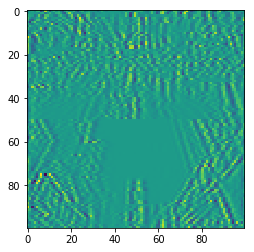

In [23]:
plt.imshow(bk_img.reshape(100,100))

이미지에 noise를 주는 함수

In [24]:
def weird_function(x, n_iter=5):
    h = x    
    filt = torch.tensor([-1./3, 1./3, -1./3])
    for i in range(n_iter):
        zero_tensor = torch.tensor([1.0*0])
        h_l = torch.cat( (zero_tensor, h[:-1]), 0)
        h_r = torch.cat((h[1:], zero_tensor), 0 )
        h = filt[0] * h + filt[2] * h_l + filt[1] * h_r
        if i % 2 == 0:
            h = torch.cat( (h[h.shape[0]//2:],h[:h.shape[0]//2]), 0  )
    return h

In [25]:
random_tensor = torch.randn(10000,dtype=torch.float)

In [26]:
random_tensor

tensor([ 0.2742, -0.5797,  1.8693,  ...,  1.1025,  0.7601,  1.0015])

In [27]:
wrd_img = weird_function(random_tensor)

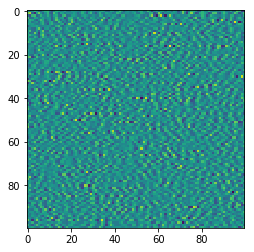

In [28]:
plt.imshow(wrd_img.reshape(100,100))

학습을 위해 사용되는 손실함수. 여기서는 단순한 거리를 오차로 사용함

In [29]:
def distance_loss(hypothesis, broken_image):
    return torch.dist(hypothesis, broken_image)

In [30]:
distance_loss(wrd_img, bk_img)

tensor(12.3236, dtype=torch.float64)

경사하강시, 학습률을 0.8로 지정하여 진행

경사하강법에서 학습률이 너무 높은 경우, 다음 point가 최적점을 지나 다른 경사에 이를 수 있으므로 적절한 크기로 설정해야 한다.

그러나, 경사가 너무 낮은 경우에는 학습에 대한 속도가 느려질 수 있다.

In [33]:
lr = 0.8

우리가 random_tensor에 대해 이미지 복원을 진행하고 있으므로, 미분값 활용을 위해 requires_grad를 True로 설정한다.

그 후 직접 구현한 경사하강법에 의해서 다음 텐서를 이동한다.

In [34]:
for i in range(0,20000):
    # loss.backward()시 계산되는 미분 값을 grad 변수에 저장하기 위하여 True로 설정
    random_tensor.requires_grad_(True)
    hypothesis = weird_function(random_tensor)
    #복원할 가설 이미지와 broken_image간의 손실값(거리) 계산
    loss = distance_loss(hypothesis, bk_img)
    # 미분계산
    loss.backward()
    
    #경사하강법을 직접 구현하기 위해 자동 기울기 계산을 비활성화 한다.
    with torch.no_grad():
        random_tensor = random_tensor - lr*random_tensor.grad
        
    if i%1000 == 0:
        print("loss at {} = {}".format(i,loss.item()))

loss at 0 = 12.32359717462535
loss at 1000 = 1.1058391936027425
loss at 2000 = 0.5320146415496683
loss at 3000 = 0.3698935246616151
loss at 4000 = 0.29249782375650585
loss at 5000 = 0.2449335588954857
loss at 6000 = 0.21078589892863248
loss at 7000 = 0.18365932472507365
loss at 8000 = 0.16062296158575917
loss at 9000 = 0.14018063699142694
loss at 10000 = 0.12149205989081296
loss at 11000 = 0.10404451335713374
loss at 12000 = 0.0875050926336512
loss at 13000 = 0.07164825294985412
loss at 14000 = 0.05631702847841168
loss at 15000 = 0.04140104587687363
loss at 16000 = 0.026824478860953904
loss at 17000 = 0.02115900605683905
loss at 18000 = 0.021165757604569353
loss at 19000 = 0.02116717369245155


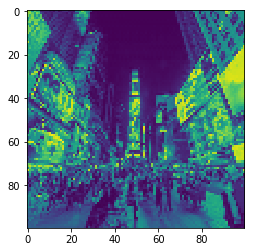

In [35]:
plt.imshow(random_tensor.reshape(100,100))

## 3.3. 신경망 모델 구현하기

### 3.1.1. 인공신경망 (ANN)

인공신경망에는 입력층, 은닉층, 그리고 출력층으로 구성되어 있다.

각 층에 존재하는 가중치를 행렬곱하고 편향을 더해줌으로써 인공신경망이 입력층에서 출력층으로 흐르게 된다.

* 가중치: 입력신호가 출력에 주는 영향을 계산하는 매개변수
* 편향: 각 노드가 얼마나 데이터에 민감한지 알려주는 매개 변수
* 활성화함수: 앞선 행렬곱의 결과를 가지고 인공 뉴런의 결과값을 산출하는 함수
(입력 신호의 합이 활성화를 일으키는지 아닌지 결정하는 역할)

인공신경망의 결과값을 활용하여 실제 값과의 오차를 계산하고, 이를 기반으로 신경망 전체를 학습시켜야 한다.

해당 오차를 가지고 인공신경망의 모든 가중치를 변경하기 위해, 출력층의 가중치부터 입력층의 가중치까지 차례대로 조정하고 최적화해야한다.

이를 위한 알고리즘이 역전파(Backpropagation)알고리즘.

**역전파 알고리즘에 대해 더 알고 싶다면??**

<a href="https://www.youtube.com/watch?v=573EZkzfnZ0">lec9-2: 딥넷트웍 학습 시키기 (backpropagation)</a>


### 3.2.2. 간단한 분류 모델 만들기

In [46]:
import torch
import numpy as np
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
import torch.nn.functional as F

n_dim = 2

x_train, y_train = make_blobs(n_samples=80,n_features=n_dim, centers=[[1,1],[-1,-1],[1,-1],[-1,1]],shuffle=True,cluster_std=0.3)

x_test, y_test = make_blobs(n_samples=20,n_features=n_dim, centers=[[1,1],[-1,-1],[1,-1],[-1,1]],shuffle=True,cluster_std=0.3)

def label_map(y_,from_,to_):
    y = np.copy(y_)
    for f in from_:
        y[y_==f] = to_
    return y

y_train = label_map(y_train, [0,1], 0)
y_train = label_map(y_train, [2,3], 1)
y_test = label_map(y_test, [0,1], 0)
y_test = label_map(y_test, [2,3], 1)


x_train = torch.FloatTensor(x_train)
x_test = torch.FloatTensor(x_test)
y_train = torch.FloatTensor(y_train)
y_test = torch.FloatTensor(y_test)

class NeuralNet(torch.nn.Module):
    # NeuralNet 선언시 모델 생성을 위한 Element 생성
    def __init__ (self,input_size,hidden_size):
        super(NeuralNet, self).__init__()
        self.input_size= input_size
        self.hidden_size = hidden_size
        
        self.linear_1 = torch.nn.Linear(self.input_size, self.hidden_size)
        self.relu = torch.nn.ReLU()
        self.linear_2 = torch.nn.Linear(self.hidden_size, 1)
        self.sigmoid = torch.nn.Sigmoid()
        
    # Neural Net모델을 순서대로 선언 및 결과 return
    def forward(self, input_tensor):
        linear1 = self.linear_1(input_tensor)
        relu = self.relu(linear1)
        linear2=self.linear_2(relu)
        output = self.sigmoid(linear2)
        return output
    
model = NeuralNet(2,5)
learning_rate = 0.03
# 이진 데이터 분류를 위한 손실함수
criterion = torch.nn.BCELoss()

epochs = 2000

optimizer = torch.optim.SGD(model.parameters(),lr=learning_rate)

model.eval()
test_loss_before = criterion(model(x_test).squeeze(),y_test)
print('Before Training, test loss is {}'.format(test_loss_before.item()))

Before Training, test loss is 0.739341139793396


학습 진행

일반적인 딥러닝 모델은, 데이터 셋을 순회하는 횟수인 epoch 뿐 만 아니라, 하나의 epoch을 일정한 크기로 나누어 학습하는 batch라는 단위로 나누어 학습을 진행하지만 해당 데이터 셋은 80개 밖에 되지 않는 작은 데이터이기 때문에 별도의 batch로 나누지 않았다.

In [48]:
for epoch in range(epochs):
    
    # 딥러닝 모델의 학습을 선언
    model.train()
    # 옵티마이저에 적용된 경사 값을 0으로 설정
    optimizer.zero_grad()
    # 모델에 x 값을 넣어 학습을 수행
    train_output = model(x_train)
    # 학습을 통해 얻은 손실 값
    train_loss = criterion(train_output.squeeze(),y_train)
    # 100회마다 Training의 손실 값 계산
    if epoch % 100 == 0:
        print('Train loss at {} is {}'.format(epoch,train_loss.item()))
        
    # 역전파 수행
    # 훈련의 손실함수에 대한 미분값 계산
    train_loss.backward()
    # 미분값을 가지고 선언한 옵티마이저에 대한 경사값 계산
    optimizer.step()
    
# 모델을 평가함을 선언
model.eval()
# 학습 후 결과값 예측 수행
test_loss_after = criterion(model(x_test).squeeze(),y_test)
print('After Training, test loss is {}'.format(test_loss_after.item()))

Train loss at 0 is 0.731960654258728
Train loss at 100 is 0.6892956495285034
Train loss at 200 is 0.6518157720565796
Train loss at 300 is 0.5864021182060242
Train loss at 400 is 0.4923781752586365
Train loss at 500 is 0.3933964669704437
Train loss at 600 is 0.3052423596382141
Train loss at 700 is 0.24037298560142517
Train loss at 800 is 0.19637033343315125
Train loss at 900 is 0.16513167321681976
Train loss at 1000 is 0.14234428107738495
Train loss at 1100 is 0.12493030726909637
Train loss at 1200 is 0.11102978140115738
Train loss at 1300 is 0.09960576146841049
Train loss at 1400 is 0.09006675332784653
Train loss at 1500 is 0.08207051455974579
Train loss at 1600 is 0.07531947642564774
Train loss at 1700 is 0.06949944794178009
Train loss at 1800 is 0.06443387269973755
Train loss at 1900 is 0.059992123395204544
After Training, test loss is 0.14222046732902527


학습한 모델의 state값을 저장하기 위한 코드

In [49]:
torch.save(model.state_dict(),'./model.pt')
print('state_dict format of model: {}'.format(model.state_dict()))

state_dict format of model: OrderedDict([('linear_1.weight', tensor([[ 1.2776,  1.2982],
        [-1.2176,  1.7109],
        [ 1.7182, -1.2113],
        [-0.5728,  0.8135],
        [ 1.0385, -0.7486]])), ('linear_1.bias', tensor([-0.0925, -0.3761, -0.1181, -0.1534, -0.0978])), ('linear_2.weight', tensor([[-1.6932,  2.0690,  1.9416,  0.9120,  1.1262]])), ('linear_2.bias', tensor([-2.1958]))])
